In [196]:
import jieba as jb, matplotlib as mpl, matplotlib.pyplot as plt, numpy as np, os, pandas as pd, re

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

jb.set_dictionary('/Users/chungyuetman/Desktop/dict.txt.big')

removing symbols, punctuations, and stopwords

In [240]:
import matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.font_manager import FontProperties
import pycantonese

stop_words = pycantonese.stop_words()
stop_words = list(stop_words)
stopwords = [',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', 
             '（', '）', ',', ':', 'hi', 'auntie', 'ok', '向左走', '向右走', '大家', '利申', 
             '雖然', '但係', '乜', '一齊', '可以', '應該', '好多', '已經', '因為', '邊個',
             '好似', '而家', '一定', '即刻', '好過', '仲有', '如果', '其實', '一半',
             '有人', '個人', '一次', '無人', '好好', '根本', '一樣', '成日', '問題', '不過',
             '有時', '之後', '沒有', '所以', '不如', '個個', '無法','見到','時候','特別','然後',
             '完全','本身','有個','最後','幾個','有無','la','今日','dcard','學生','大學生','先知','聽到','一個','全部','感覺']

stopwords.extend(stop_words)

mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.subplot.bottom'] = .1
ChineseFont1 = FontProperties(fname='/Users/chungyuetman/Downloads/HanaMinA.ttf')
sns.set(color_codes=True)

Used jieba.cut for tokenization.

In [241]:
def sent_token(sent, StopWords=True, RemoveHttp=True):
  if RemoveHttp == True:
    sent = re.sub(r'^https?:\/\/.*[\r\n]*', '', sent, flags=re.MULTILINE)
  words = '/'.join(jb.cut(sent)).split('/')
  if StopWords == True:
    words = [w for w in words if w not in stopwords]
  return words

Topics = n_components

In [246]:
def tfidfvectorizer(words_list, max_features=100, n_top_words=50, n_components=10, return_model=False):
  def print_top_words(model, feature_names, n_top_words):
   for topic_idx, topic in enumerate(model.components_):
       print("Topic #%d:" % topic_idx)
       print(" ".join([feature_names[i]
                         for i in topic.argsort()[:-n_top_words - 1:-1]]))
   print()

  sents = []
  for words in words_list:
    sents.append(' '.join(words))
  vtr = CountVectorizer(max_df=0.85, min_df=2,
                        max_features=max_features)
  vtr_sents = vtr.fit_transform(sents)

  lda = LatentDirichletAllocation(n_components=n_components, 
                                  max_iter=10,
                                  learning_method='online',
                                  learning_offset=50,
                                  random_state=12345)
  lda.fit(vtr_sents)
  if return_model == True:
     return lda, vtr_sents, vtr
  vtr_feature_names = vtr.get_feature_names_out()
  #print_top_words(lda, vtr_feature_names, n_top_words) 
  lda_words_list = []
  for topic_idx, topic in enumerate(lda.components_):
    term = [topic_idx, [vtr_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]]
    lda_words_list.append(term)
  return lda_words_list

  

In [243]:
file = '/Users/chungyuetman/Desktop/sosc4100/final_result.xlsx'
data = pd.read_excel(file, engine = "openpyxl")
split_date ='2019-12-31'
df_2020 = data.loc[data['date'] > split_date]
df_2019 = data.loc[data['date'] <= split_date]

excerpt_2019 = df_2019['excerpt']
excerpt_2020 = df_2020['excerpt']
data = data['excerpt']

def data_processing(df):
  words_list = []
  #df = excerpt_2019
  sents = df.values
  for sent in sents:
      if not isinstance(sent, str):
        continue
      sent = sent.split('|')
      for s in sent:
        words_list.append(sent_token(s))
        
  return tfidfvectorizer(words_list, return_model=True)

In [247]:
sklearn_lda, sklearn_wordvec, sklearn_wordvecmodel = data_processing(data)

In [ ]:
sklearn_lda, sklearn_wordvec, sklearn_wordvecmodel = data_processing(excerpt_2020)

pyLDA_2020 = pyLDAvis.sklearn.prepare(sklearn_lda, sklearn_wordvec, sklearn_wordvecmodel, mds='tsne')
pyLDAvis.save_html(pyLDA_2020, 'ldavis_golden_2020.html')

In [138]:
#Hyperparameter Tuning and evaluation 

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Options to try with our LDA
# Beware it will try *all* of the combinations, so it'll take ages
search_params = {'n_components': range(3,10), 'learning_decay': [.5, .7]}

# Set up LDA with the options we'll keep static
model = LatentDirichletAllocation(learning_method='online', ## `online` for large datasets
                                  max_iter=10,
                                  learning_offset=50,
                                  random_state=12345)

# Try all of the options
gridsearch = GridSearchCV(model,
                          param_grid=search_params,
                          n_jobs=-1,
                          verbose=1)
gridsearch.fit(sklearn_wordvec)

## Save the best model
best_lda = gridsearch.best_estimator_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [139]:
# What did we find?
print("Best Model's Params: ", gridsearch.best_params_)
print("Best Log Likelihood Score: ", gridsearch.best_score_)
print('Best Model Perplexity: ', best_lda.perplexity(sklearn_wordvec))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 3}
Best Log Likelihood Score:  -8566.77378355198
Best Model Perplexity:  99.87483105980182


<AxesSubplot:xlabel='param_n_components', ylabel='mean_test_score'>

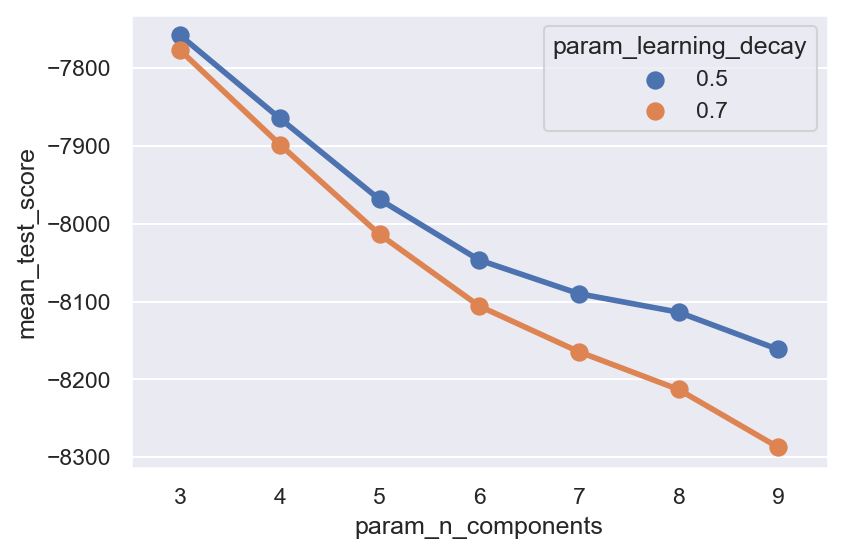

In [100]:
import seaborn as sns
cv_results_df = pd.DataFrame(gridsearch.cv_results_)
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.pointplot(x="param_n_components",
              y="mean_test_score",
             hue="param_learning_decay",
              data=cv_results_df)

In [117]:

from matplotlib.font_manager import FontProperties

def proportion_of_topic(model, feature_names, num_top_words=10, num_topics=5):
  components = model.components_.T
  word_topic = components / np.sum(components, axis=0)
  fontsize_base = 70 / np.max(word_topic)
  for i in range(num_topics):
    plt.subplot(1, num_topics, i + 1)
    plt.ylim(0, num_top_words + 0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title('Topic #{}'.format(i))
    top_words_idx = np.argsort(word_topic[:, i])[::-1]
    top_words_idx = top_words_idx[:num_top_words]
    top_words = []
    for idx in top_words_idx:
      top_words.append(feature_names[idx])
    top_words_shares = word_topic[top_words_idx, i]
    for j, (word, share) in enumerate(zip(top_words, top_words_shares)):
      plt.text(0.3, num_top_words-j-0.5, word, fontsize=fontsize_base*share, fontproperties=ChineseFont1)
  plt.show()


In [118]:
from wordcloud import get_single_color_func, WordCloud
class GroupedColorFunc(object):
      # Source: https://amueller.github.io/word_cloud/auto_examples/colored_by_group.html?highlight=color_func
  def __init__(self, color_to_words, default_color):
    self.color_func_to_words = [
        (get_single_color_func(color), set(words))
        for (color, words) in color_to_words.items()]
    self.default_color_func = get_single_color_func(default_color)

  def get_color_func(self, word):
    """Returns a single_color_func associated with the word"""
    try:
      color_func = next(
          color_func for (color_func, words) in self.color_func_to_words
          if word in words)
    except StopIteration:
      color_func = self.default_color_func
    return color_func

  def __call__(self, word, **kwargs):
    return self.get_color_func(word)(word, **kwargs)

In [190]:
import random 
def word_clouds(terms, groupbycolor=True, num_top_words=20, num_topics=5):
  def terms_to_wordcounts(terms, multiplier=1000):
    wordcounts = ''
    for i in terms:
      for j in range(num_top_words):
        wordcounts += ' '.join(int(((num_top_words - j) * multiplier)) * [i[1][j]])
    return wordcounts
  wordcounts = terms_to_wordcounts(terms)
  font_path = '/Users/chungyuetman/Downloads/HanaMinA.ttf'
  wordcloud = WordCloud(font_path=font_path, background_color='white', collocations=False).generate(wordcounts)
  if groupbycolor == True:
    default_color = 'grey'
    color_list = []
    r = lambda: random.randint(200, 255)
    for i in range(num_topics):
      color_list.append('#%02X%02X%02X' % (r(), r(), r()))
    color_to_words = {color_list[i]: terms[i][1] for i in range(num_topics)}
    grouped_color_func = GroupedColorFunc(color_to_words, default_color)
    wordcloud.recolor(color_func=grouped_color_func)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

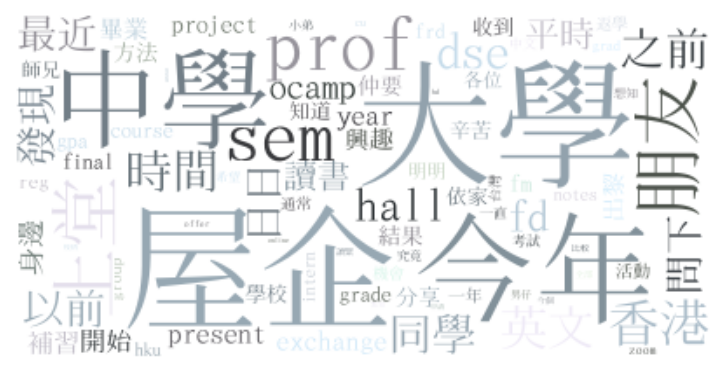

In [233]:
def main():
  words_list = []
  df = data
  sents = df.values
  for sent in sents:
      if not isinstance(sent, str):
        continue
      sent = sent.split('|')
      for s in sent:
        words_list.append(sent_token(s))
  lda_words_list = tfidfvectorizer(words_list)
  word_clouds(lda_words_list)
  #sklearn_lda, sklearn_wordvec, sklearn_wordvecmodel = tfidfvectorizer(words_list, return_model=True)
  #proportion_of_topic(sklearn_lda, sklearn_wordvecmodel.get_feature_names())
      

if __name__ == '__main__':
  main()
